# Task 2 : Analyse data

# Task 2.1 :  Data Cleaning

## Step 01 : Removing any unnecessary characters or symbols (e.g., punctuation, special characters)

In [9]:
import pandas as pd 
df = pd.read_csv('British_Airways_reviews')

In [10]:
import string

def remove_punctuation(text):
    return ''.join([char.lower() for char in text if char.isalnum() or char.isspace()])


df['reviews'] = df['reviews'].apply(lambda x: remove_punctuation(x))


In [11]:
#removing the index
df.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df.head()

,reviews
0,trip verified starting off at heathrow term...
1,not verified we have flown this route with e...
2,trip verified a last minute business trip to...
3,trip verified overall i would say disappoi...
4,not verified lhr to delhi in business except...


In [13]:
df['reviews'] = df['reviews'].str.replace('trip verified', '')
df['reviews'] = df['reviews'].str.replace('not verified' , '')
df['reviews'] = df['reviews'].str.replace('ba' , 'bad')

## Step 02 : Remove stopwords (commonly used words like "the", "is", "and", etc.) that do not carry much meaning.

In [14]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Define a function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.split()  # Split text into individual words
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)

# Apply the function to the 'cleaned_reviews_step_01' column (assuming Step 01 has been completed)
df['reviews'] = df['reviews'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 03 : Lemmatization

**Lemmatization helps in standardizing words so that variations of the same word are treated as the same token.**

For example:

- The lemma of the word "running" is "run".
- The lemma of the word "cars" is "car".
- The lemma of the word "better" is "good".

In [15]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization
def lemmatize_text(text):
    # Tokenize the text into words
    tokens = text.split()
    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in tokens]
    # Join the lemmatized tokens back into text
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


df['reviews'] = df['reviews'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /home/repl/nltk_data...


# Task 2.2 : Topic Modeling

In [16]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim


# Tokenize the lemmatized text in the 'reviews' column
tokenized_reviews = df['reviews'].apply(lambda x: x.split())

# Create a dictionary representation of the tokenized reviews
dictionary = corpora.Dictionary(tokenized_reviews)

# Filter out extreme or infrequent words
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Convert the dictionary to a Bag of Words corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_reviews]

# Build the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# Print the topics
for idx, topic in lda_model.print_topics():
    print("Topic {}: {}".format(idx + 1, topic))

# Visualize the topics
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

Topic 1: 0.014*"seat" + 0.011*"time" + 0.010*"london" + 0.009*"service" + 0.008*"crew" + 0.008*"british" + 0.008*"book" + 0.007*"fly" + 0.007*"one" + 0.007*"airways"
Topic 2: 0.014*"seat" + 0.013*"service" + 0.010*"board" + 0.009*"get" + 0.008*"us" + 0.008*"good" + 0.007*"cabin" + 0.007*"time" + 0.007*"crew" + 0.007*"staff"
Topic 3: 0.022*"seat" + 0.013*"airways" + 0.011*"british" + 0.011*"fly" + 0.010*"service" + 0.008*"london" + 0.008*"food" + 0.007*"first" + 0.007*"time" + 0.007*"staff"
Topic 4: 0.014*"time" + 0.014*"get" + 0.011*"service" + 0.011*"seat" + 0.009*"staff" + 0.008*"london" + 0.007*"food" + 0.007*"book" + 0.006*"hours" + 0.006*"board"
Topic 5: 0.011*"get" + 0.011*"service" + 0.010*"fly" + 0.009*"seat" + 0.009*"class" + 0.008*"cancel" + 0.008*"business" + 0.008*"crew" + 0.008*"time" + 0.008*"london"


Based on the topics generated by the LDA model, here are the main themes or topics present in this  customer reviews df :

Topic 1: Seat and Time
- Keywords: seat, time, service, class, make, British, get, book, one, fly

Topic 2: British Airways Service
- Keywords: British, US, Airways, get, seat, service, one, fly, staff, hours

Topic 3: Service and Flying Experience
- Keywords: seat, service, fly, time, London, hours, get, one, first, customer

Topic 4: Service Quality
- Keywords: get, seat, would, service, call, crew, London, fly, food, good

Topic 5: Business Class Experience
- Keywords: seat, service, time, board, business, class, get, crew, food, good

These topics provide an overview of the main subjects discussed in our customer reviews, such as seat comfort, service quality, flying experience, and business class amenities. 

## Creating column : Topic 

In [17]:
def assign_topic(review_text):
    # Tokenize the review text
    tokens = review_text.split()
    # Convert the tokens to bag of words representation
    bow = dictionary.doc2bow(tokens)
    # Get the topic distribution for the review
    topic_distribution = lda_model.get_document_topics(bow)
    # Get the topic with the highest probability
    dominant_topic = max(topic_distribution, key=lambda item: item[1])[0]
    return dominant_topic

# Apply the function to create the 'topic' column
df['topic'] = df['reviews'].apply(assign_topic)

In [18]:
df['topic'].unique()

array([1, 0, 4, 2, 3])

In [19]:
# Create a mapping dictionary for topic titles
topic_mapping = {
    0: "Seat and Time",
    1: "British Airways Service",
    2: "Service and Flying Experience",
    3: "Service Quality",
    4: "Business Class Experience"
}

# Replace numerical topic identifiers with topic titles
df['topic'] = df['topic'].map(topic_mapping)


In [20]:

# Count the frequency of each topic
df['topic'].value_counts()


topic
British Airways Service          307
Business Class Experience        203
Seat and Time                    190
Service Quality                  172
Service and Flying Experience    128
Name: count, dtype: int64

# Task 2.3 : sentiment analysis

In [21]:
from textblob import TextBlob

# Define a function to perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment analysis function to the 'reviews' column
df['sentiment'] = df['reviews'].apply(analyze_sentiment)


## Sentiment Distribution

In [22]:
df['sentiment'].value_counts()

sentiment
Positive    568
Negative    420
Neutral      12
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



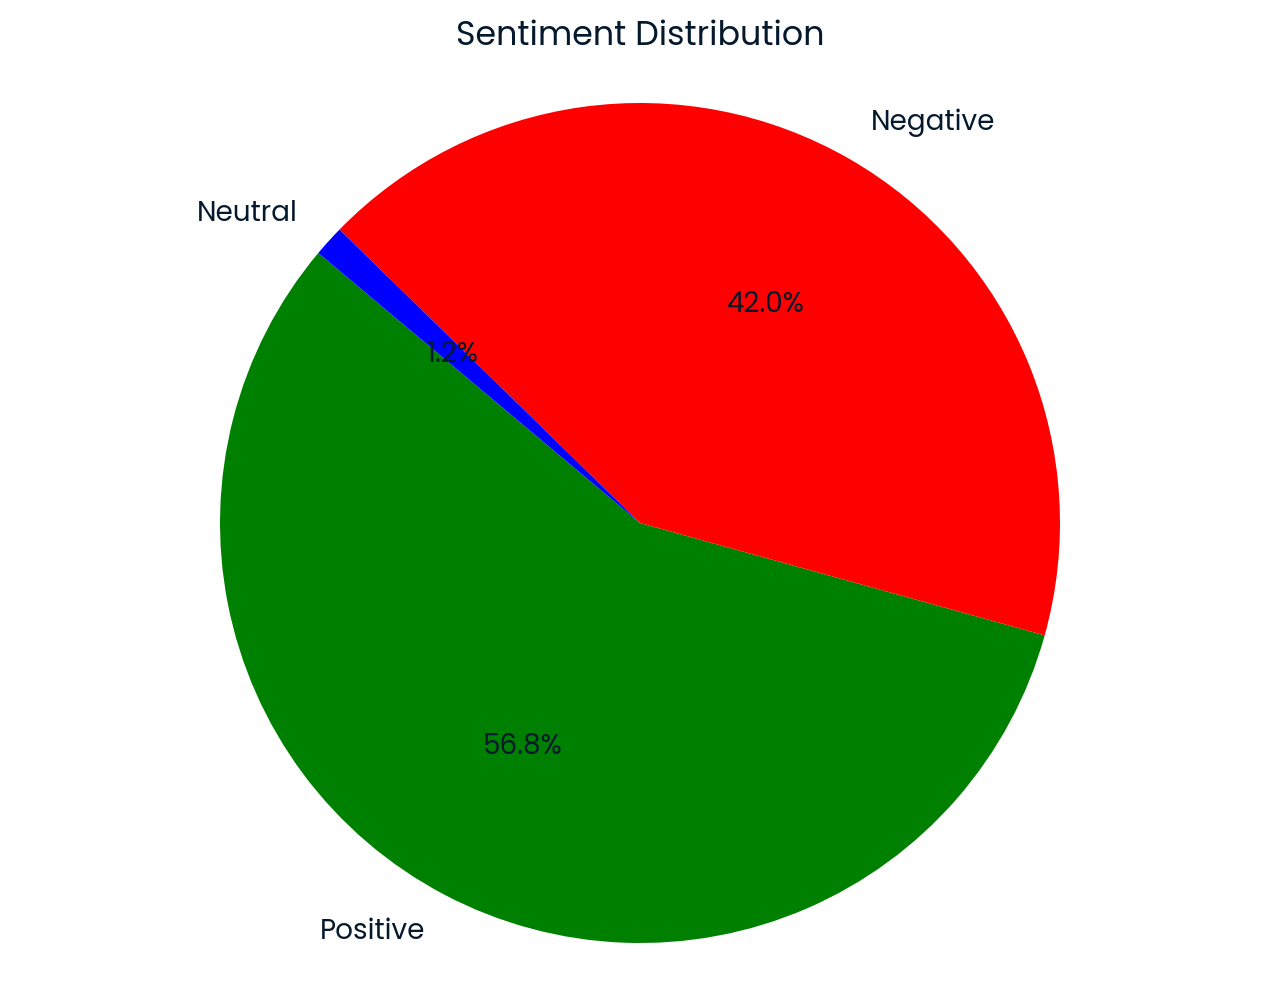

In [23]:
import matplotlib.pyplot as plt

# Calculate the count of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'blue'])
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


# Task 2.4 :  Topic-Sentiment Analysis

## Calculate Sentiment within Each Topic

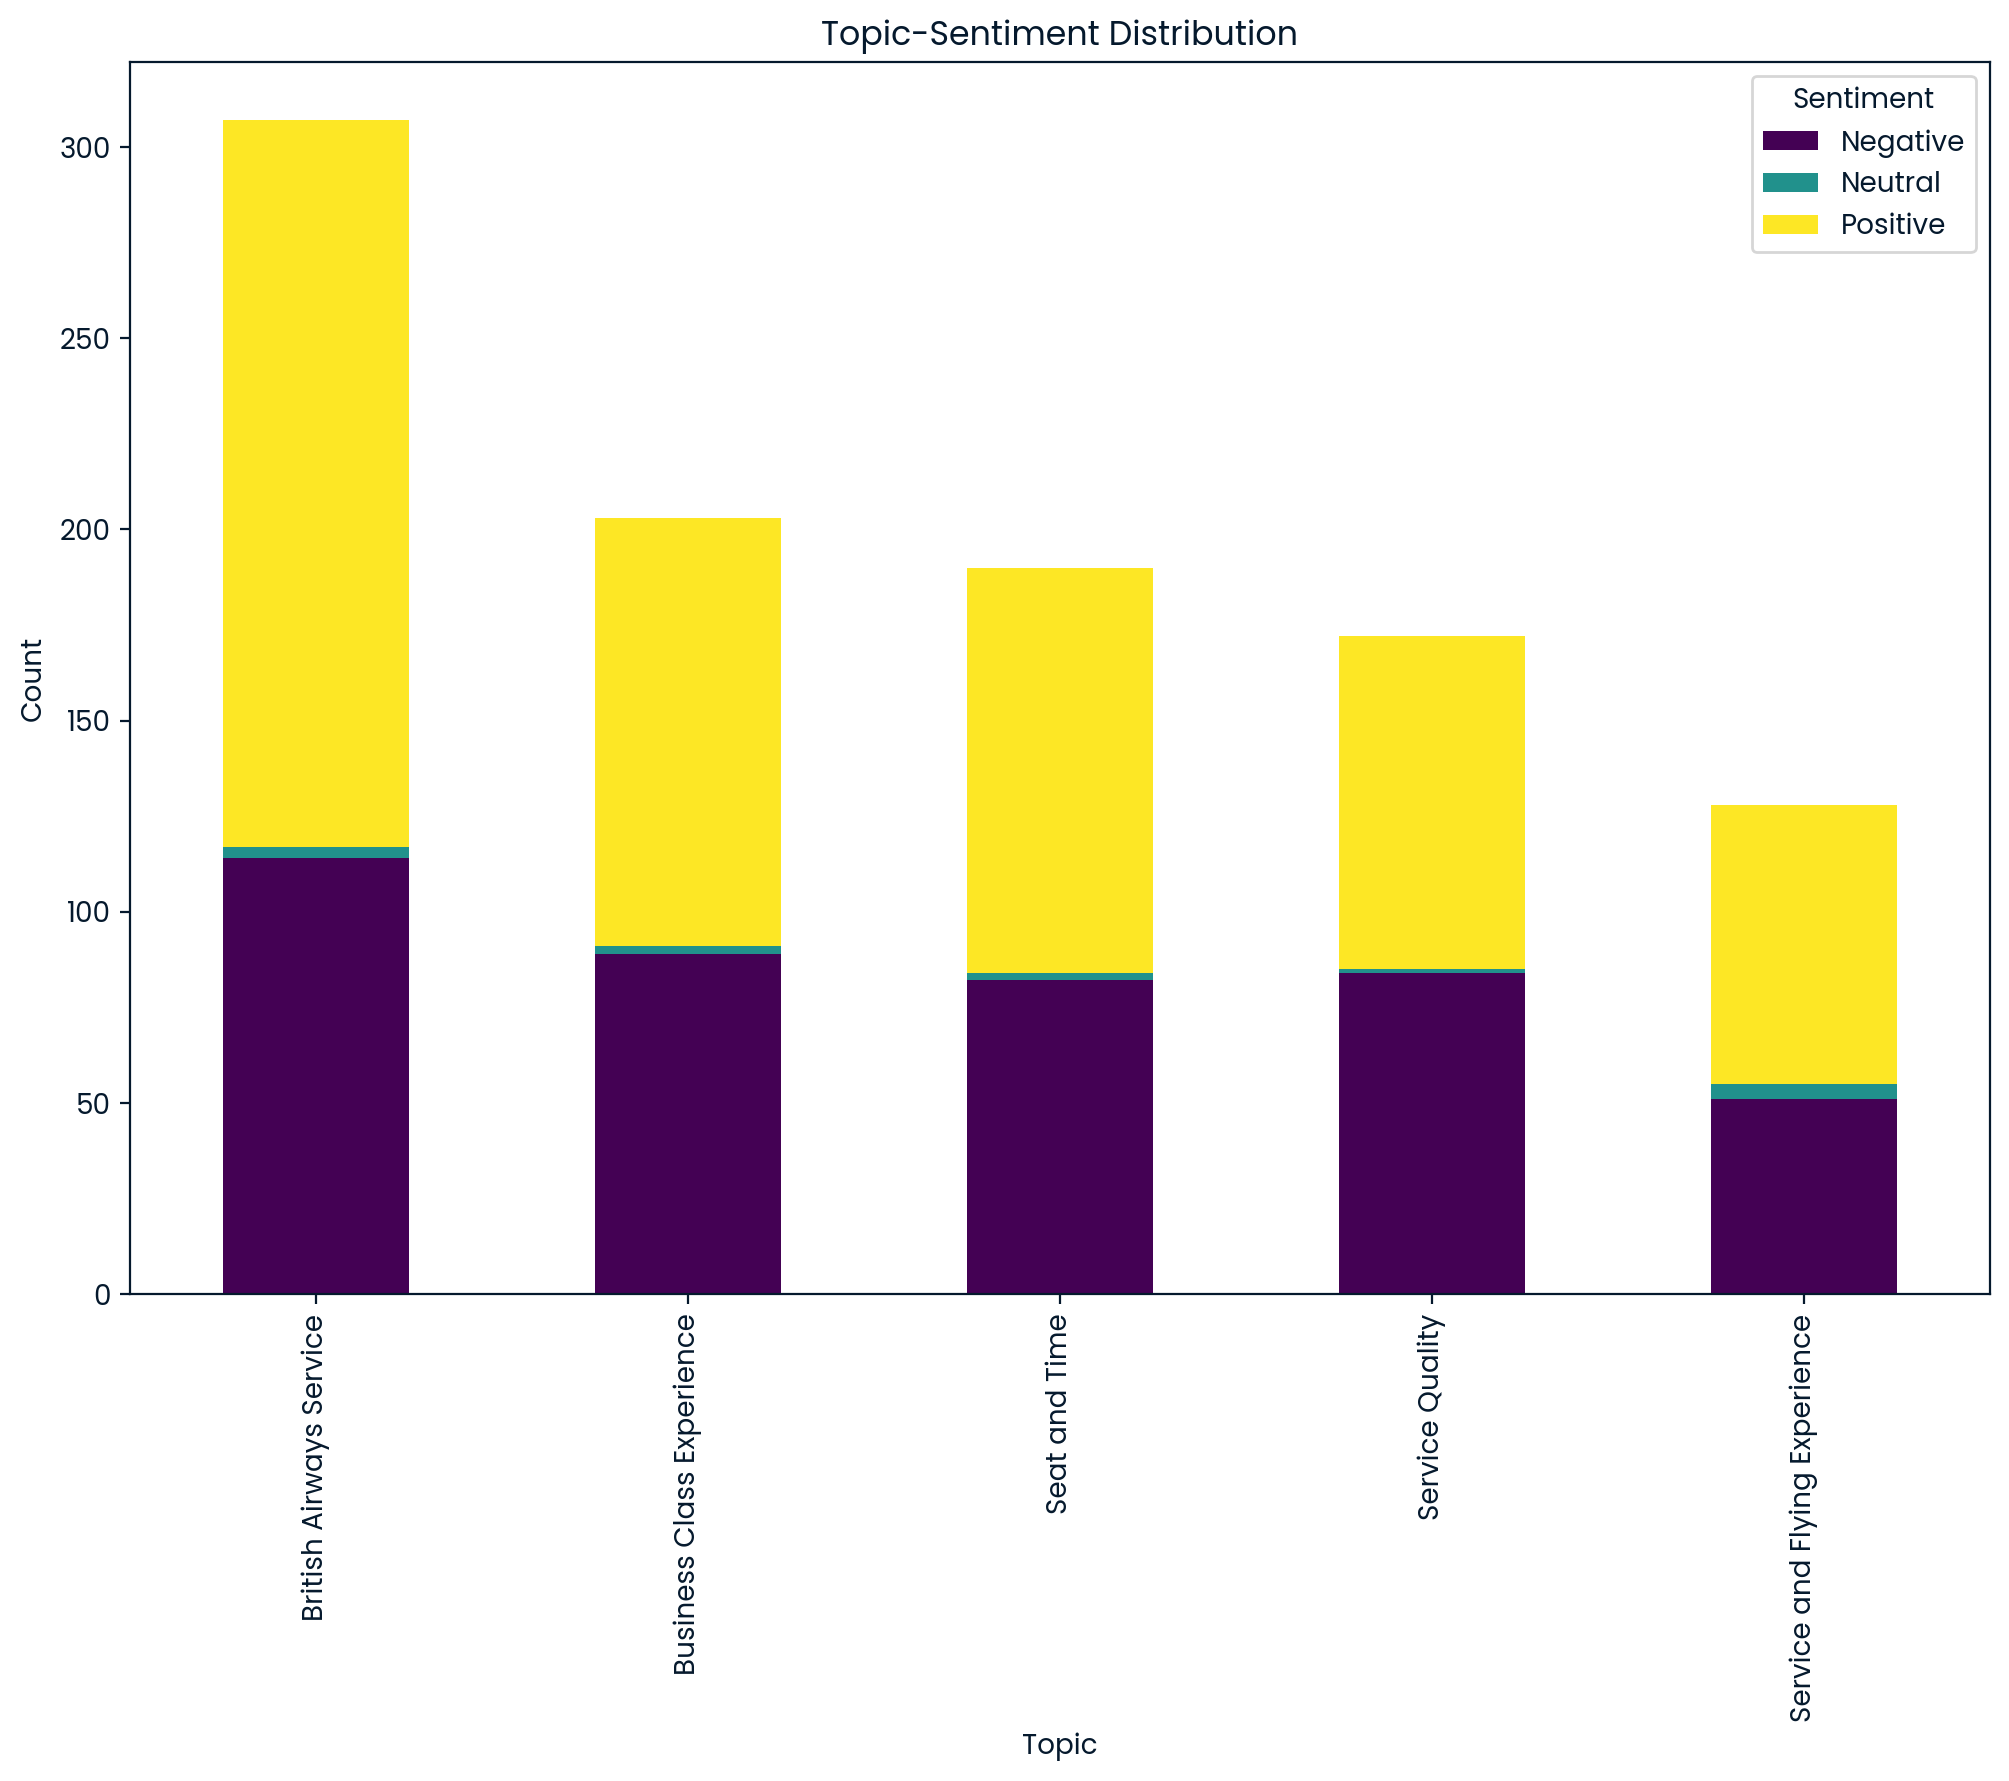

In [24]:
df.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)

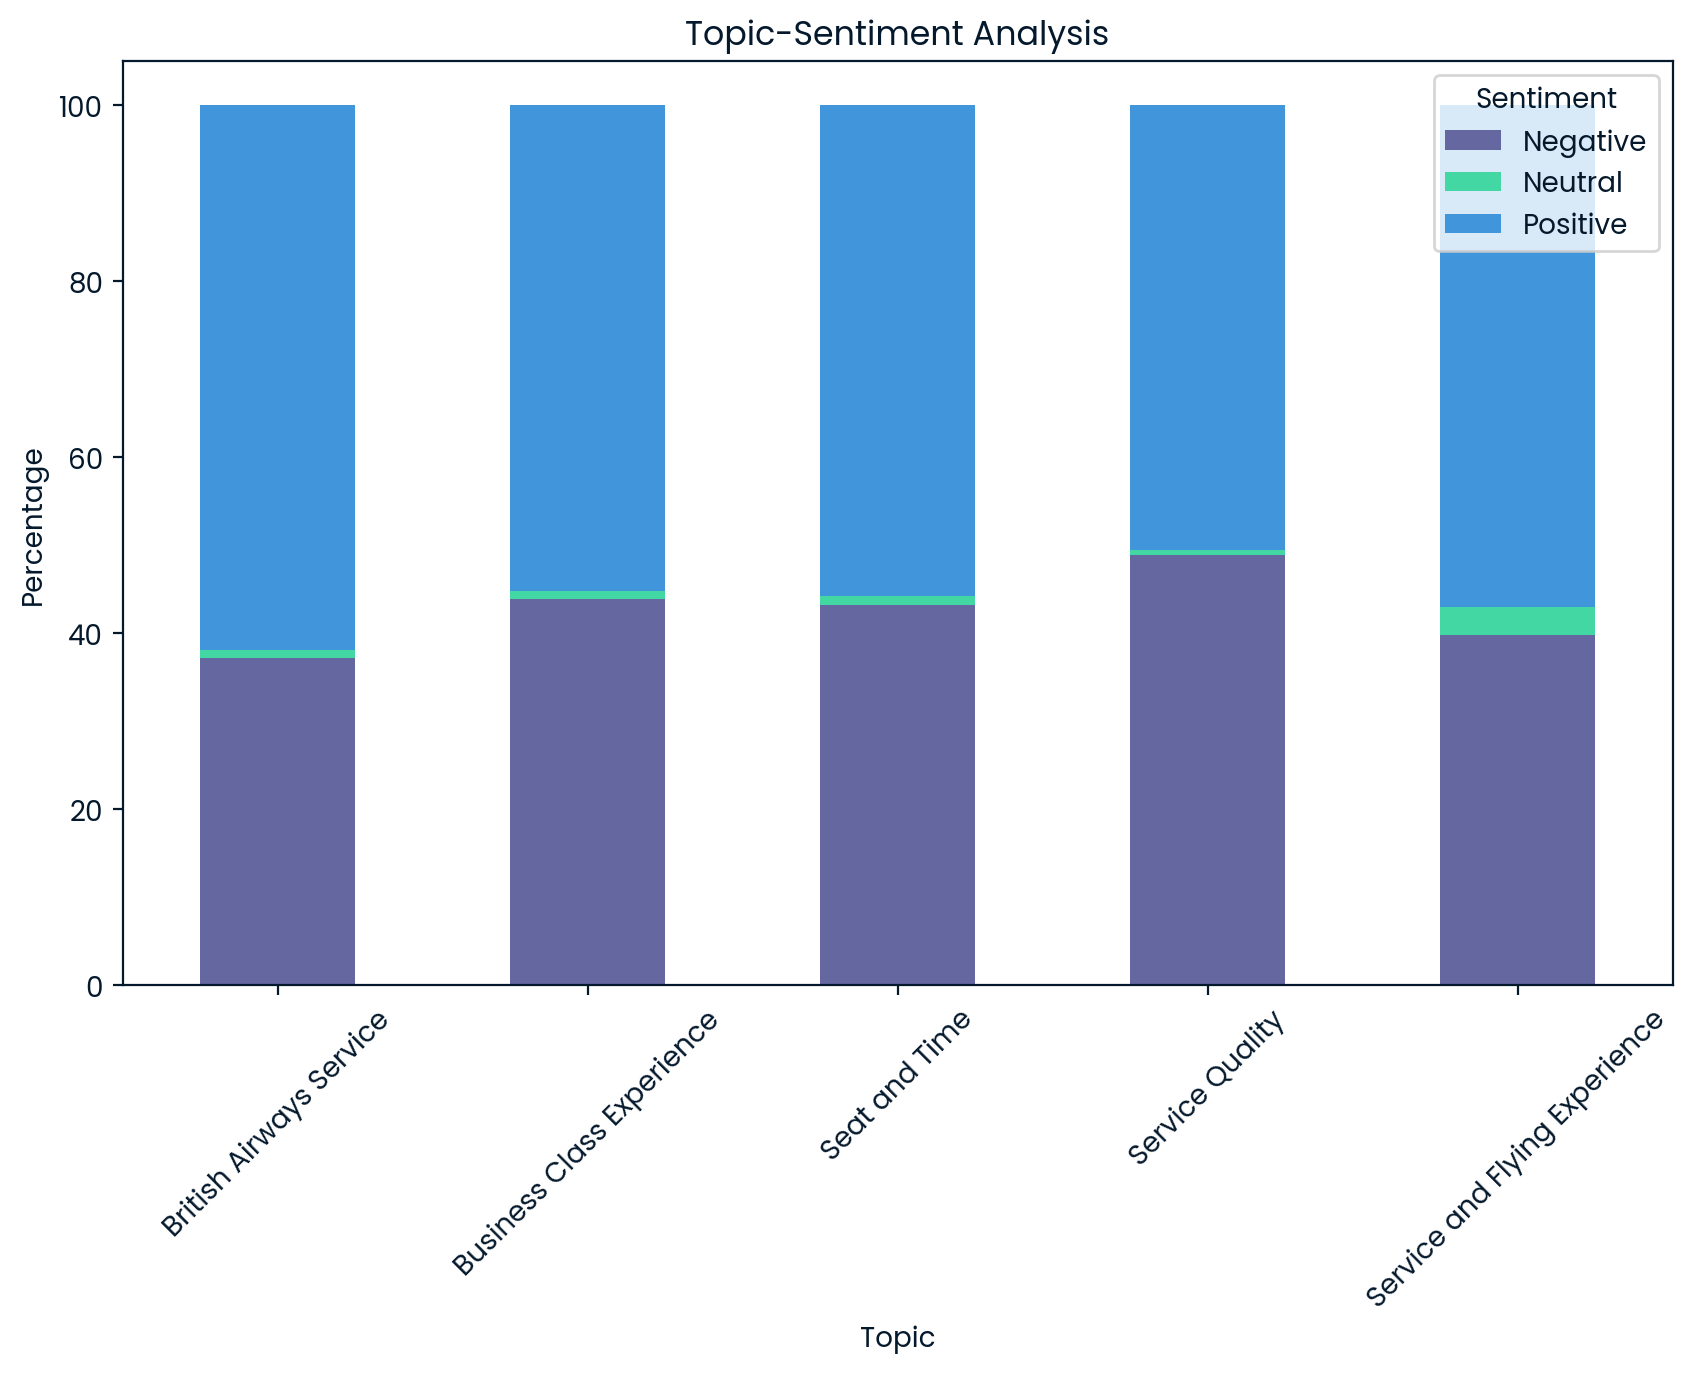

In [25]:

# Calculate sentiment distribution within each topic cluster
topic_sentiment_counts = df.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)

# Normalize counts to obtain percentages
topic_sentiment_percentages = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar plot for Topic-Sentiment Analysis
topic_sentiment_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Topic-Sentiment Analysis')
plt.xlabel('Topic')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()


# Task 2.5 : Word Clouds

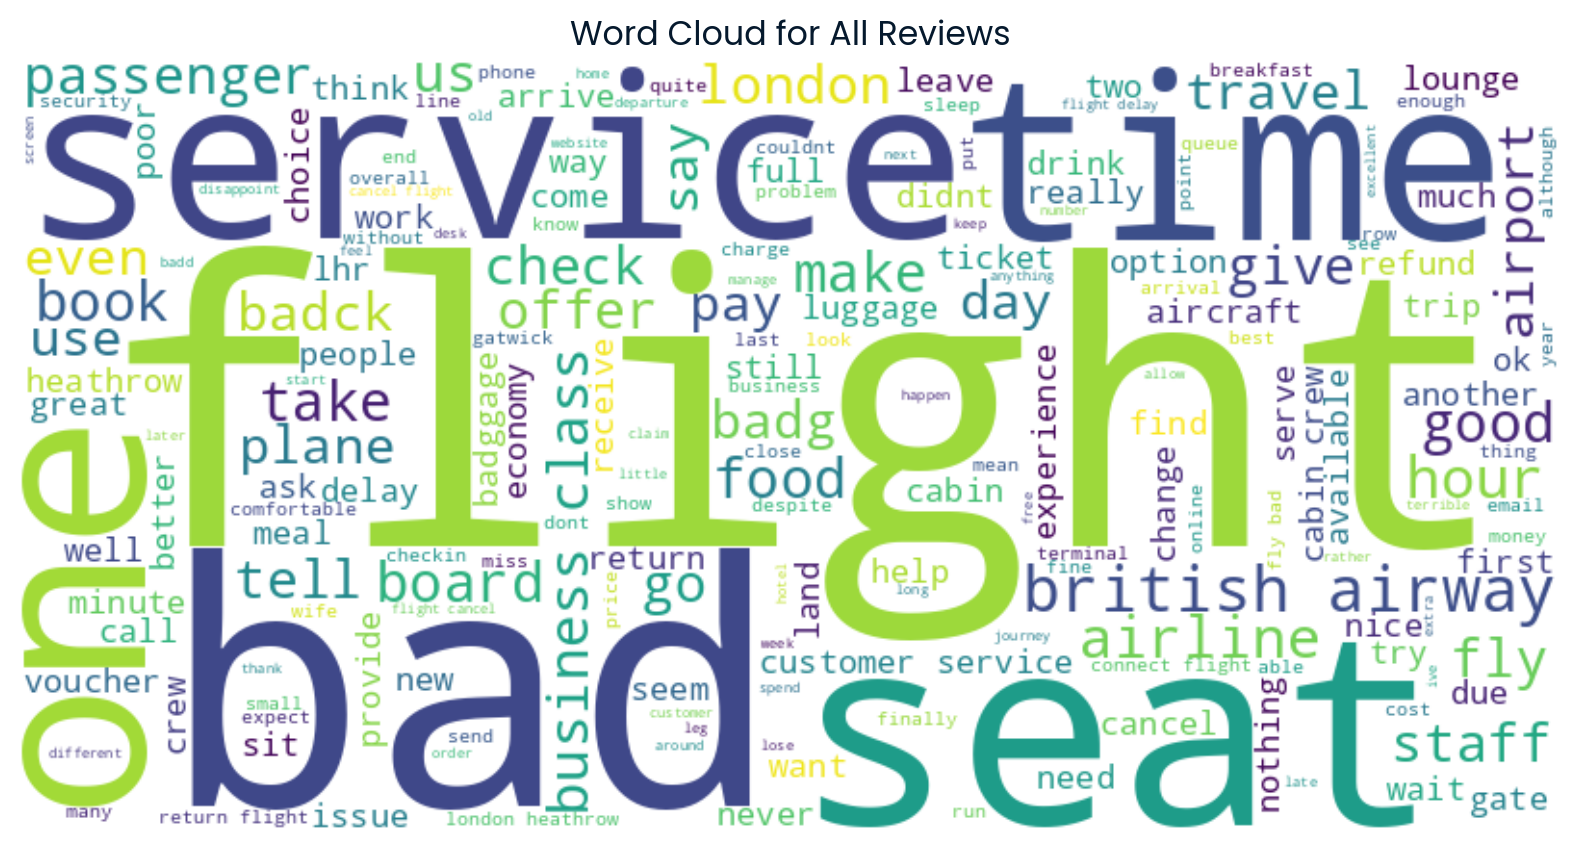

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
all_reviews = ' '.join(df['reviews'])

# Generate word cloud for all reviews
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for All Reviews')
plt.axis('off')
plt.show()
